In [1]:
import torch
import torch.nn as nn

from tqdm import tqdm
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader


In [2]:
# set the seed for future work
seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)



In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),  # Random crop and resize to 224x224
        transforms.RandomRotation(30),      # Randomly rotate by up to 30 degrees
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalization
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
}

dataset_classify = datasets.ImageFolder('data/borderline_negative/')

train_size = int(0.8 * len(dataset_classify))
test_size = len(dataset_classify) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset_classify, [train_size, test_size])

In [4]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)
    
train_dataset = CustomDataset(train_dataset, transform=data_transforms['train'])
test_dataset = CustomDataset(test_dataset, transform=data_transforms['test'])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# classes in train_loader:
for x, y in train_loader:
    print(y)
    break

tensor([1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0,
        1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0,
        1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 0])


In [5]:
# Load pretrained model
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# Freeze the model parameters
for param in model.parameters():
    param.requires_grad = False

modelOutputFeats = model.fc.in_features
model.fc = nn.Linear(modelOutputFeats, len(dataset_classify.classes))

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003)

In [7]:
# use gpu if available
device = torch.device("cuda:0") # change to CPU if no CUDA
model.to(device)
criterion.to(device)

CrossEntropyLoss()

In [8]:
num_epochs = 15 # Number of epochs

for epoch in range(num_epochs):
    # unfreeze the last layer
    if epoch == 7:
        for param in model.layer4.parameters():
            param.requires_grad = True

    # Training loop
    model.train()

    running_loss = 0.0
    num_batches = 0
    train_correct = 0
    for inputs, labels in tqdm(train_loader):
        optimizer.zero_grad()
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = model(inputs)

        loss = criterion(outputs, labels)

        running_loss, num_batches = running_loss + loss.item(), num_batches + 1
        # Backward and optimize
        loss.backward()
        optimizer.step()
        train_correct += (outputs.argmax(dim=1) == labels).sum().item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/num_batches:.4f}, correct during training: {train_correct}')

    model.eval()
    # Validation loop
    with torch.no_grad():
        running_accuracy = 0.0
        total_correct = 0 
        num_batches = 0
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            num_batches += 1
            total_correct += (outputs.argmax(dim=1) == labels).type(torch.float).sum().item()
        running_accuracy = total_correct / len(test_loader.dataset) * 100
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Test Accuracy: {running_accuracy}%')


100%|██████████| 19/19 [02:31<00:00,  7.97s/it]


Epoch [1/15], Loss: 0.6715, correct during training: 1377
Epoch [1/15], Test Accuracy: 60.86235489220564%


100%|██████████| 19/19 [02:32<00:00,  8.03s/it]


Epoch [2/15], Loss: 0.6359, correct during training: 1529
Epoch [2/15], Test Accuracy: 65.67164179104478%


100%|██████████| 19/19 [02:30<00:00,  7.93s/it]


Epoch [3/15], Loss: 0.6204, correct during training: 1615
Epoch [3/15], Test Accuracy: 67.66169154228857%


100%|██████████| 19/19 [02:29<00:00,  7.89s/it]


Epoch [4/15], Loss: 0.6074, correct during training: 1633
Epoch [4/15], Test Accuracy: 67.66169154228857%


100%|██████████| 19/19 [02:30<00:00,  7.92s/it]


Epoch [5/15], Loss: 0.5924, correct during training: 1675
Epoch [5/15], Test Accuracy: 68.32504145936981%


100%|██████████| 19/19 [02:39<00:00,  8.39s/it]


Epoch [6/15], Loss: 0.5898, correct during training: 1680
Epoch [6/15], Test Accuracy: 68.32504145936981%


100%|██████████| 19/19 [02:35<00:00,  8.21s/it]


Epoch [7/15], Loss: 0.5812, correct during training: 1690
Epoch [7/15], Test Accuracy: 68.82255389718075%


100%|██████████| 19/19 [02:37<00:00,  8.28s/it]


Epoch [8/15], Loss: 0.5662, correct during training: 1671
Epoch [8/15], Test Accuracy: 70.48092868988391%


100%|██████████| 19/19 [02:36<00:00,  8.26s/it]


Epoch [9/15], Loss: 0.5087, correct during training: 1797
Epoch [9/15], Test Accuracy: 70.97844112769486%


100%|██████████| 19/19 [02:35<00:00,  8.19s/it]


Epoch [10/15], Loss: 0.4736, correct during training: 1823
Epoch [10/15], Test Accuracy: 69.65174129353234%


100%|██████████| 19/19 [02:34<00:00,  8.12s/it]


Epoch [11/15], Loss: 0.4233, correct during training: 1924
Epoch [11/15], Test Accuracy: 72.4709784411277%


100%|██████████| 19/19 [02:35<00:00,  8.17s/it]


Epoch [12/15], Loss: 0.4071, correct during training: 1948
Epoch [12/15], Test Accuracy: 74.7927031509121%


100%|██████████| 19/19 [02:34<00:00,  8.15s/it]


Epoch [13/15], Loss: 0.3685, correct during training: 1999
Epoch [13/15], Test Accuracy: 75.787728026534%


100%|██████████| 19/19 [02:34<00:00,  8.14s/it]


Epoch [14/15], Loss: 0.3440, correct during training: 2038
Epoch [14/15], Test Accuracy: 73.30016583747927%


100%|██████████| 19/19 [02:36<00:00,  8.24s/it]


Epoch [15/15], Loss: 0.3172, correct during training: 2047
Epoch [15/15], Test Accuracy: 73.46600331674958%


In [12]:
checkpoint = {
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': criterion,
    'classes': dataset_classify.classes
}
torch.save(checkpoint, 'checkpoints/model_finetuned.pt')

In [13]:
classes = checkpoint['classes']

In [27]:
#captum occlusion visualization
import numpy as np
from captum.attr import Occlusion
import matplotlib.pyplot as plt
from captum.attr import visualization as viz
occlusion = Occlusion(model)

# get a sample
with torch.no_grad():
    sample = next(iter(test_loader))
    images, labels = sample
    images = images.to(device)
    labels = labels.to(device)
    # predict
    pred = model(images)
    pred = pred.argmax(dim=1)
    # get attribution
    attribution = occlusion.attribute(images,
                                    strides=(3, 9, 9),
                                    target=labels, 
                                    sliding_window_shapes=(3,15,15),
                                    baselines=0)

Standard Deviation: [0.229, 0.224, 0.225]


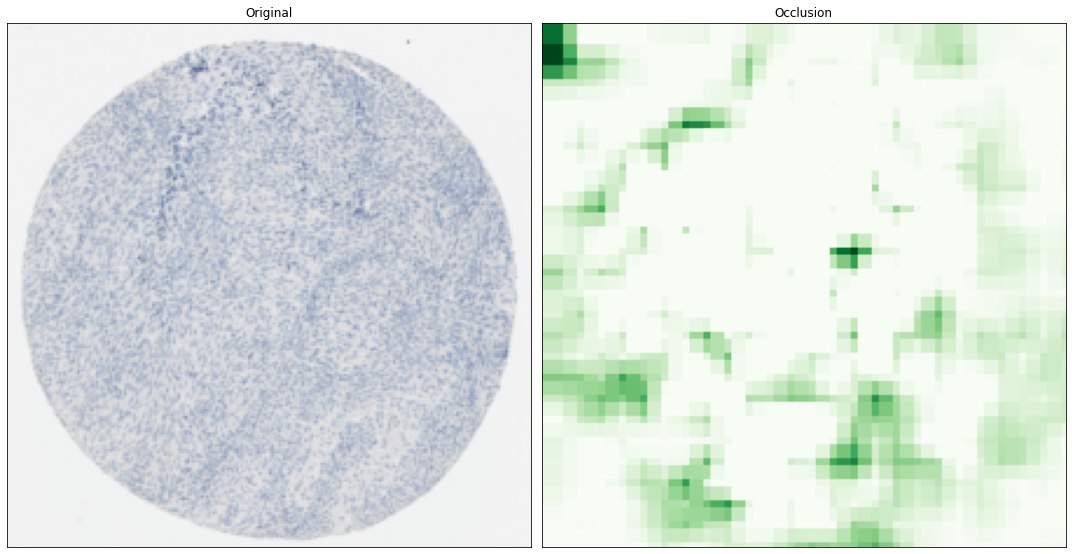

<Figure size 432x288 with 0 Axes>

In [36]:
# Ensure correct transposition for visualization of a single sample
index = 0  # Choose the index of the sample you want to visualize
attribution_single = np.transpose(attribution[index].squeeze().cpu().detach().numpy(), (1, 2, 0))  # (Height, Width, Channels)
image_single = np.transpose(images[index].squeeze().cpu().detach().numpy(), (1, 2, 0))  # (Height, Width, Channels)

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Denormalize the single image
denormalized_image_single = (image_single * std) + mean

# Visualize the single sample attribution and image
_ = viz.visualize_image_attr_multiple(
    attribution_single,
    denormalized_image_single,
    methods=["original_image", "heat_map"],
    signs=["all", "positive"],
    titles=["Original", "Occlusion"],
    fig_size=(15, 15),
    use_pyplot=True  # Set to True if using matplotlib directly in the notebook
)
plt.savefig('occlusion.png')
